In [1]:
### Library
import numpy as np
import pandas as pd

import timeit
import time
import os
from datetime import datetime
from pathlib import Path

from tqdm import tqdm
from tqdm.auto import trange
import ipynbname

import warnings
import pickle
import json
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
from torchmetrics import regression
from collections import defaultdict

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoDiagonalNormal

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'> Using device: {device}')

def set_seed(seed=12):
    np.random.seed(seed)
    torch.manual_seed(seed)
    pyro.set_rng_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

pyro.clear_param_store()
plt.style.use('ggplot')
set_seed(12)


> Using device: cuda:0


In [2]:
parameter_gama = 4.0
parameter_gama_rate = 0.5
parameter_prior_scale_input = 7.0
parameter_prior_scale_hidden = 8.0
parameter_prior_scale_output = 4.0

class BNN(PyroModule):
    def __init__(self, in_dim=5, out_dim=75, hid_dim=128, device='cuda'):
        super(BNN, self).__init__()
        self.activation = nn.LeakyReLU(0.1)
        self.dropout = PyroModule[nn.Dropout](0.05)
        self.out_dim = out_dim  
        self.device = device

        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, hid_dim)
    
    # 5 layers for 5 scenarios
        self.layer4_sc1 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc2 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc3 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc4 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc5 = PyroModule[nn.Linear](hid_dim, out_dim)

        # Prior scales
        self.prior_scale_input = parameter_prior_scale_input
        self.prior_scale_hidden = parameter_prior_scale_hidden
        self.prior_scale_output = parameter_prior_scale_output

        # Set priors for each layer
        self.layer1.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, in_dim, device=device),
                        self.prior_scale_input * torch.ones(hid_dim, in_dim, device=device)).to_event(2)
        )
        self.layer1.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_input * torch.ones(hid_dim, device=device)).to_event(1)
        )

        self.layer2.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, hid_dim, device=device)).to_event(2)
        )
        self.layer2.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, device=device)).to_event(1)
        )

        self.layer3.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, hid_dim, device=device)).to_event(2)
        )
        self.layer3.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, device=device)).to_event(1)
        )

        # Priors for 5 scenarios output layers
        for sc in range(1, 6):
            layer = getattr(self, f"layer4_sc{sc}")
            layer.weight = PyroSample(
                dist.Normal(torch.zeros(out_dim, hid_dim, device=device),
                            self.prior_scale_output * torch.ones(out_dim, hid_dim, device=device)).to_event(2)
            )
            layer.bias = PyroSample(
                dist.Normal(torch.zeros(out_dim, device=device),
                            self.prior_scale_output * torch.ones(out_dim, device=device)).to_event(1)
            )

    def forward(self, x, y=None):
        x = x.to(self.device).float()
        batch_size = x.shape[0]
        if len(x.shape) > 2:
            x = x.reshape(batch_size, -1)

        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        residual = x
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
        x = self.activation(self.layer3(x))
        x = x + residual

        # Calculate mu for each scenario
        mu_sc1 = self.layer4_sc1(x)
        mu_sc2 = self.layer4_sc2(x)
        mu_sc3 = self.layer4_sc3(x)
        mu_sc4 = self.layer4_sc4(x)
        mu_sc5 = self.layer4_sc5(x)
        mu = torch.stack([mu_sc1, mu_sc2, mu_sc3, mu_sc4, mu_sc5], dim=1)  # [batch_size, 5, 76]

        # Sample df and sigma
        df = pyro.sample("df", 
                        dist.Gamma(concentration=torch.tensor(parameter_gama, device=self.device), 
                                rate=torch.tensor(parameter_gama_rate, device=self.device)))
        sigma = pyro.sample("sigma", 
                        dist.HalfCauchy(torch.ones(5, self.out_dim, device=self.device)).to_event(2))

        # Chose likelihood for each scenario
        with pyro.plate("data", batch_size):
            for i in range(5):
                pyro.sample(f"obs_sc{i}", 
                        dist.StudentT(df=df, loc=mu[:, i, :], scale=sigma[i, :]).to_event(1), 
                        obs=y[:, i, :] if y is not None else None)

        return mu
    
    def hyperparameter_init(self, loss_func, guide, optimizer):
        self.loss_func = loss_func
        self.guide = guide
        self.optimizer = optimizer
        self.svi = SVI(self, self.guide, self.optimizer, loss=self.loss_func)
        self.history = {}
        self.save_path = None
        return

    def epoch_train(self, data_input, data_output):
        epoch_loss = self.svi.step(data_input, data_output) / data_input.shape[0]
        return epoch_loss

    def stop_condition(self, tol, patience, num_epochs):
        epoch = len(self.history['train_loss']) - 1
        self.max_epoch = epoch
        if epoch < 1:
            self.best_epoch = 0
            return False

        if self.history['train_loss'][epoch] <= self.history['train_loss'][self.best_epoch]:
            self.best_epoch = epoch
            self.best_guide = self.guide
            self.best_param_store = pyro.get_param_store()
            self.best_history = {key: value[epoch] for key, value in self.history.items()}

        if self.history['train_loss'][epoch] <= tol:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching the tolerance of {tol:.3f}')
            return True

        if epoch + 1 >= patience and min(self.history['train_loss'][-patience:]) > self.history['train_loss'][self.best_epoch]:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching maximum patience of {patience}')
            return True

        if epoch + 1 == num_epochs:
            print(f'> Model stopping at epoch {epoch+1:03} due to reaching maximum epochs {num_epochs}')
            return True
        return False

    def plot_loss(self):
        if epoch < 1:
            plt.ion()  # Turn on interactive mode
            plt.rcParams['text.usetex'] = True
            self.fig, self.ax = plt.subplots(figsize=(8, 6))
            self.train_loss_line, = self.ax.plot([], [], label="Train Loss", color='b',
                                                linestyle='-', linewidth=2)
            self.fig.suptitle(r'\textbf{Training history}', y=0.99, fontsize=16)
            self.ax.set_xlabel('Epochs', fontsize=12)
            self.ax.set_ylabel('Loss', fontsize=12)
            self.ax.tick_params(axis='x', labelsize=10)
            self.ax.tick_params(axis='y', labelsize=10)
            self.ax.set_yscale('log')
            self.ax.legend(loc='upper right', fontsize=10)
            plt.tight_layout()
            plt.grid(True)
            # self.fig.canvas.manager.window.activateWindow()
            # self.fig.canvas.manager.window.raise_()
        else:
            self.train_loss_line.set_data(range(epoch+1), self.history["train_loss"])

            self.ax.set_xlim(0, epoch + 1)
            self.ax.set_ylim(min(self.history["train_loss"])*0.8, max(self.history["train_loss"])*1.2)
            # self.ax.relim()
            # self.ax.autoscale_view()

            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
        return

In [3]:
### Make result directory
script_dir = os.path.abspath('')
current_file = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt_string = datetime.now().strftime("%y%m%d_%H%M%S")
result_dir = os.path.join(script_dir, 'Results', current_file, dt_string)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [4]:
### Get data
data_df = pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'full_data_sampling.csv'), index_col=0, header=0)
data_df = data_df.drop_duplicates()

input_variables = ['$x_{1}$', '$x_{2}$', '$x_{3}$', '$x_{5}$', '$x_{8}$']
input_variables_names = ["$x_{1}$: External wall thickness (mm)", 
                         "$x_{2}$: Internal wall thickness (mm)", 
                         "$x_{3}$: Thermal conductivity of Wall bricks (W/mK)", 
                         "$x_{5}$: Thermal resistance of Roof infill-blocks (m$^{2}$K/W)",
                         "$x_{8}$: Indoor air temperature (°C)", 
                         "$z$: Climate change scenario"]
output_variables = [f'$y^{{{year}}}$' for year in range(2026, 2101)]

lst_input_features = []
lst_output_features = []

grouped = data_df.groupby('idx')
for design, group in tqdm(grouped):
    input_features = group[input_variables].iloc[0].values.tolist()
    output_features = group[output_variables].values.tolist()
    lst_input_features.append(input_features)
    lst_output_features.append(output_features)

# Convert to numpy arrays
lst_input_features = np.array(lst_input_features)
lst_output_features = np.array(lst_output_features)

# Scale input data
scaler_input = StandardScaler().fit(lst_input_features)
input_array = scaler_input.transform(lst_input_features)

# Scale output data
scalers_output = [StandardScaler().fit([lst_output_features[i][j].tolist() for i in range(len(lst_output_features))]) for j in range(lst_output_features.shape[1])]
output_array = np.stack([scalers_output[j].transform([lst_output_features[i][j].tolist() for i in range(len(lst_output_features))]) for j in range(lst_output_features.shape[1])], axis=1)

# Convert to tensors
data_input_tensor = torch.tensor(input_array, dtype=torch.float32).to(device)
data_output_tensor = torch.tensor(output_array, dtype=torch.float32).to(device)
torch.cuda.empty_cache()
# data_tensor = TensorDataset(data_input_tensor, data_output_tensor)

# print('----- Data demonstration -----')
# print(f'> Input data:')
# print(f'Input tensor shape: {data_input_tensor.shape}')
# print(f'> Output data:')
# print(f'Output tensor shape: {data_output_tensor.shape}')

# print('----- Data summary -----')
# print(f'> Number of data samples: {len(data_tensor)} samples')

100%|██████████| 199200/199200 [00:51<00:00, 3867.84it/s]


In [5]:
### Load saved model
load_path = os.path.join(script_dir, 'Results', 'BNN_Model', '250326_085053', '091909')

pyro.clear_param_store()
model = torch.load(os.path.join(load_path, 'BNN_model.pt'), map_location=device, weights_only=False)
with open(os.path.join(load_path, 'Best_BNN_guide.pkl'), 'rb') as f:
    guide = pickle.load(f)
    
# Load the params file with weights_only=False
with open(os.path.join(load_path, 'Best_BNN_params.pt'), 'rb') as input_file:
    state = torch.load(input_file, map_location=device, weights_only=False)
    
# Set the state in the param store
pyro.get_param_store().set_state(state)


In [6]:
### Evaluate the model
print('----- Model evaluation -----')
model.eval()
guide.requires_grad_(False)

train_best_loss = model.history["train_loss"][model.best_epoch]
recal_best_loss = Trace_ELBO().loss(model, guide, data_input_tensor, data_output_tensor) / data_input_tensor.shape[0]

print(f'> Saved best loss: {train_best_loss:.3f}')
print(f'> Recalculated best loss: {recal_best_loss:.3f}')

predictive = Predictive(model, guide=guide, num_samples=200, return_sites=("_RETURN", "obs_sc0", "obs_sc1", "obs_sc2", "obs_sc3", "obs_sc4"))

mean_obs_output = data_output_tensor.reshape(-1, 200, 5, 75).permute(1, 0, 2, 3).cpu().numpy().mean(axis=0)
data_unique_tensor = torch.from_numpy(pd.DataFrame(data_input_tensor.cpu().numpy()).drop_duplicates().values).float().to(device)
mean_pred_output = predictive(data_unique_tensor)['_RETURN'].cpu().numpy().mean(axis=0)
# mean_pred_output = torch.stack([predictive(data_unique_tensor)[f'obs_sc{i}'] for i in range(5)], dim=2).cpu().numpy().mean(axis=0)

mean_obs_output = np.array([scalers_output[i].inverse_transform(mean_obs_output[:, i, :]) for i in range(lst_output_features.shape[1])]).transpose(1, 0, 2)
mean_pred_output = np.array([scalers_output[i].inverse_transform(mean_pred_output[:, i, :]) for i in range(lst_output_features.shape[1])]).transpose(1, 0, 2)

RMSE = np.sqrt(mean_squared_error(mean_obs_output.flatten(), mean_pred_output.flatten()))
MAPE = mean_absolute_percentage_error(mean_obs_output.flatten(), mean_pred_output.flatten())*100.

print(f'> Overall RMSE: {RMSE:.3f}')
print(f'> Overall MAPE: {MAPE:.3f}%')

RMSE_list = [np.sqrt(mean_squared_error(mean_obs_output[i,:], mean_pred_output[i,:]))
             for i in range(mean_obs_output.shape[0])]
MAPE_list = [mean_absolute_percentage_error(mean_obs_output[i,:], mean_pred_output[i,:])*100
             for i in range(mean_obs_output.shape[0])]

print(f'> Per-sample RMSE: {np.min(RMSE_list):.3f} (Min), {np.mean(RMSE_list):.3f} (Mean), {np.max(RMSE_list):.3f} (Max)')
print(f'> Per-sample MAPE: {np.min(MAPE_list):.3f}% (Min), {np.mean(MAPE_list):.3f}% (Mean), {np.max(MAPE_list):.3f}% (Max)')

----- Model evaluation -----
> Saved best loss: -60.083
> Recalculated best loss: -16.450
> Overall RMSE: 0.591
> Overall MAPE: 1.767%
> Per-sample RMSE: 0.061 (Min), 0.503 (Mean), 1.463 (Max)
> Per-sample MAPE: 0.288% (Min), 1.767% (Mean), 3.851% (Max)


In [7]:
def find_pred_output_tensor(random_samples, scaler_input, scalers_output, predictive):
    random_sample_input_tensor = scaler_input.transform(random_samples)
    random_sample_input_tensor = torch.from_numpy(random_sample_input_tensor).float().to(device)

    pred_output = torch.stack([predictive(random_sample_input_tensor)[f'obs_sc{i}'] for i in range(5)], dim=2)

    pred_output_tensor = {
        'mean': torch.mean(pred_output, 0),
        'low_5': pred_output.kthvalue(int(len(pred_output) * 0.05), dim=0)[0],
        'high_95': pred_output.kthvalue(int(len(pred_output) * 0.95), dim=0)[0],
    }

    for key, value in pred_output_tensor.items():
        pred_output_tensor[key] = np.stack([scalers_output[i].inverse_transform(value[:,i,:].cpu().numpy()) for i in range(value.shape[1])], axis=1).transpose(2,1,0)
        pred_output_tensor[key] = [pd.DataFrame(pred_output_tensor[key][:,i,:], index=range(2026,2101)) for i in range(value.shape[1])]

    pred_output_tensor['data'] = np.stack([scalers_output[i].inverse_transform(pred_output[:,:,i,:].cpu().numpy().transpose(1,0,2).reshape(-1,75)) for i in range(pred_output.shape[2])], axis=1)
    pred_output_tensor['data'] = [pd.DataFrame(pred_output_tensor['data'][:,i,:].transpose(),
                                            index=range(2026,2101), 
                                            columns=[f'design_{j}_sample_{k}' for j in range(pred_output.shape[1]) for k in range(pred_output.shape[0])]
                                            ) for i in range(pred_output_tensor['data'].shape[1])]

    pred_output_tensor['std'] = np.stack([torch.std(pred_output, 0)[:,i,:].cpu().numpy() * scalers_output[i].scale_ for i in range(pred_output.shape[2])], axis=1).transpose(2,1,0)
    pred_output_tensor['std'] = [pd.DataFrame(pred_output_tensor['std'][:,i,:], index=range(2026,2101)) for i in range(pred_output.shape[2])]

    return pred_output_tensor

def find_pred_cost_func_tensor(pred_output_tensor, cost_func='y'):
    pred_func_tensor = dict.fromkeys(pred_output_tensor)
    if cost_func == 'y':
        pred_func_tensor = pred_output_tensor
    else:
        rho = 0.99
        std_devs = [pred_output_tensor['std'][i].to_numpy() for i in range(len(pred_output_tensor['std']))]
        corr_matrix = [rho ** np.abs(np.subtract.outer(range(len(std_devs[i])), range(len(std_devs[i])))) for i in range(len(std_devs))]

        if cost_func == 'C1':
            pred_mean_func = [torch.from_numpy(pred_output_tensor['mean'][i].cumsum().values) for i in range(len(pred_output_tensor['mean']))]
            pred_mean_func = [pred_mean_func[i]/1000 for i in range(len(pred_mean_func))]

            cov_matrix = [corr_matrix[i] * np.stack([np.outer(std_devs[i][:,j], std_devs[i][:,j]) for j in range(std_devs[i].shape[1])]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][:, 0:j+1, 0:j+1].sum(axis=(1,2))) for j in range(len(std_devs[i]))])) for i in range(len(std_devs))]
            pred_std_func = [pred_std_func[i]/1000 for i in range(len(pred_std_func))]

        elif cost_func == 'C2':
            UEE = np.array([0.3539, 0.2272, 0.2020])  # Ton CO2 / MWh
            ECR = np.array([[2024, 2030, 2050, 2100],
                            [49.6,   20,    0,    0],  # %
                            [ 3.8,  9.9,  3.0,    0],  # %
                            [   0, 14.9,  5.4,    0],  # %
                            ])
            ECR = np.array([interp1d(ECR[0,:], row, kind='linear', fill_value='extrapolate')(np.arange(2026, 2101)) for row in ECR[1:,:]/100])
            emission_factors = np.dot(ECR.transpose(), UEE).reshape(-1,1)

            pred_mean_func = [torch.from_numpy(pd.DataFrame(pred_output_tensor['mean'][i].values * emission_factors).cumsum().values) for i in range(len(pred_output_tensor['mean']))]
            
            std_devs = [std_devs[i] * emission_factors for i in range(len(std_devs))]
            cov_matrix = [corr_matrix[i] * np.stack([np.outer(std_devs[i][:,j], std_devs[i][:,j]) for j in range(std_devs[i].shape[1])]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][:, 0:j+1, 0:j+1].sum(axis=(1,2))) for j in range(len(std_devs[i]))])) for i in range(len(std_devs))]

        elif cost_func == 'C3':
            UEP = 3.302/1000  # 1,000,000,000 VND/MWh
            r = 3.39/100  # %
            compound_factors = UEP * np.array((1 + r)**(pred_output_tensor['data'][0].index - 2025)).reshape(-1,1)

            pred_mean_func = [torch.from_numpy(pd.DataFrame(pred_output_tensor['mean'][i].values * compound_factors).cumsum().values) for i in range(len(pred_output_tensor['mean']))]
            
            std_devs = [std_devs[i] * compound_factors for i in range(len(std_devs))]
            cov_matrix = [corr_matrix[i] * np.stack([np.outer(std_devs[i][:,j], std_devs[i][:,j]) for j in range(std_devs[i].shape[1])]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][:, 0:j+1, 0:j+1].sum(axis=(1,2))) for j in range(len(std_devs[i]))])) for i in range(len(std_devs))]

        pred_mean_func = torch.stack(pred_mean_func, dim=1).transpose(0,2)
        pred_std_func = torch.stack(pred_std_func, dim=1).transpose(0,2)
        z_low, z_high = stats.norm.ppf(0.5 - 0.90 / 2), stats.norm.ppf(0.5 + 0.90 / 2)
        pred_func_tensor = {
            'mean': pred_mean_func,
            'std': pred_std_func,
            'low_5': pred_mean_func + z_low * pred_std_func,
            'high_95': pred_mean_func + z_high * pred_std_func,
        }
        
        for key, value in pred_func_tensor.items():
            pred_func_tensor[key] = [pd.DataFrame(value[:,i,:].cpu().numpy().transpose(), index=range(2026,2101)) for i in range(value.shape[1])]
        
    return pred_func_tensor


In [8]:
def find_sample_output_tensor(data_df, input_variables, output_variables, random_sample, scaler_input, scalers_output, predictive):
    random_sample_input_tensor = scaler_input.transform(np.array(random_sample).reshape(1,-1))
    random_sample_input_tensor = torch.from_numpy(random_sample_input_tensor).float().to(device)
    random_sample_output_df = data_df[np.all(data_df[input_variables] == random_sample, axis=1)][output_variables]
    random_sample_output_array = random_sample_output_df.to_numpy().reshape(5, -1, 75).transpose(1, 0, 2)
    random_sample_output_array = np.stack([scalers_output[i].transform([random_sample_output_array[j][i].tolist() for j in range(len(random_sample_output_array))]) for i in range(random_sample_output_array.shape[1])], axis=1)

    sample_output_tensor = {'obs': torch.from_numpy(random_sample_output_array).float().to(device),
                            # 'pred': predictive(random_sample_input_tensor)['_RETURN'].squeeze(1)}
                            'pred': torch.stack([predictive(random_sample_input_tensor)[f'obs_sc{i}'] for i in range(5)], dim=1).squeeze(2)}

    for key, value in sample_output_tensor.items():
            sample_output_tensor[key] = {
                'mean': torch.mean(value, 0),
                'low_5': value.kthvalue(int(len(value) * 0.05), dim=0)[0],
                'high_95': value.kthvalue(int(len(value) * 0.95), dim=0)[0],
            }

            for sub_key, sub_value in sample_output_tensor[key].items():
                sample_output_tensor[key][sub_key] = np.stack([scalers_output[i].inverse_transform([sub_value[i,:].tolist()]) for i in range(sub_value.shape[0])], axis=1).reshape(5, 75).transpose()
                sample_output_tensor[key][sub_key] = [pd.DataFrame(sample_output_tensor[key][sub_key][:,i], index=range(2026,2101)) for i in range(sub_value.shape[0])]

            sample_output_tensor[key]['data'] = np.stack([scalers_output[i].inverse_transform([value[j][i].tolist() for j in range(len(value))]) for i in range(value.shape[1])], axis=1)
            sample_output_tensor[key]['data'] = [pd.DataFrame(sample_output_tensor[key]['data'][:,i,:].transpose(), index=range(2026,2101), columns=['sample_'+str(j) for j in range(sample_output_tensor[key]['data'].shape[0])]) for i in range(value.shape[1])]

            sample_output_tensor[key]['std'] = np.asarray(torch.std(value, 0).cpu().numpy() * [scalers_output[i].scale_ for i in range(value.shape[1])]).transpose()
            sample_output_tensor[key]['std'] = [pd.DataFrame(sample_output_tensor[key]['std'][:,i], index=range(2026,2101)) for i in range(sub_value.shape[0])]

    return sample_output_tensor

def find_sample_cost_func_tensor(sample_output_tensor, cost_func='y'):
    sample_func_tensor = dict.fromkeys(sample_output_tensor)
    if cost_func == 'y':
        sample_func_tensor = sample_output_tensor
    else:
        rho = 0.99
        std_devs = [sample_output_tensor['pred']['std'][i].to_numpy() for i in range(len(sample_output_tensor['pred']['std']))]
        corr_matrix = [rho ** np.abs(np.subtract.outer(range(len(std_devs[i])), range(len(std_devs[i])))) for i in range(len(std_devs))]

        if cost_func == 'C1':
            obs_data_func = [torch.from_numpy(sample_output_tensor['obs']['data'][i].cumsum().values) for i in range(len(sample_output_tensor['obs']['data']))]
            obs_data_func = [obs_data_func[i]/1000 for i in range(len(obs_data_func))]

            pred_mean_func = [torch.from_numpy(sample_output_tensor['pred']['mean'][i].cumsum().values) for i in range(len(sample_output_tensor['pred']['mean']))]
            pred_mean_func = [pred_mean_func[i]/1000 for i in range(len(pred_mean_func))]

            cov_matrix = [corr_matrix[i] * np.outer(std_devs[i], std_devs[i]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][0:j+1, 0:j+1].sum()) for j in range(len(std_devs[i]))])).view(-1, 1) for i in range(len(std_devs))]
            pred_std_func = [pred_std_func[i]/1000 for i in range(len(pred_std_func))]

        elif cost_func == 'C2':
            UEE = np.array([0.3539, 0.2272, 0.2020])  # Ton CO2 / MWh
            ECR = np.array([[2024, 2030, 2050, 2100],
                            [49.6,   20,    0,    0],  # %
                            [ 3.8,  9.9,  3.0,    0],  # %
                            [   0, 14.9,  5.4,    0],  # %
                            ])
            ECR = np.array([interp1d(ECR[0,:], row, kind='linear', fill_value='extrapolate')(np.arange(2026, 2101)) for row in ECR[1:,:]/100])
            emission_factors = np.dot(ECR.transpose(), UEE).reshape(-1,1)

            obs_data_func = [torch.from_numpy(pd.DataFrame(sample_output_tensor['obs']['data'][i].values * emission_factors).cumsum().values) for i in range(len(sample_output_tensor['obs']['data']))]
            pred_mean_func = [torch.from_numpy(pd.DataFrame(sample_output_tensor['pred']['mean'][i].values * emission_factors).cumsum().values) for i in range(len(sample_output_tensor['pred']['mean']))]
            
            std_devs = [std_devs[i] * emission_factors for i in range(len(std_devs))]
            cov_matrix = [corr_matrix[i] * np.outer(std_devs[i], std_devs[i]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][0:j+1, 0:j+1].sum()) for j in range(len(std_devs[i]))])).view(-1, 1) for i in range(len(std_devs))]

        elif cost_func == 'C3':
            UEP = 3.302/1000  # 1,000,000,000 VND/MWh
            r = 3.39/100  # %
            compound_factors = UEP * np.array((1 + r)**(sample_output_tensor['obs']['data'][0].index - 2025)).reshape(-1,1)

            obs_data_func = [torch.from_numpy(pd.DataFrame(sample_output_tensor['obs']['data'][i].values * compound_factors).cumsum().values) for i in range(len(sample_output_tensor['obs']['data']))]
            pred_mean_func = [torch.from_numpy(pd.DataFrame(sample_output_tensor['pred']['mean'][i].values * compound_factors).cumsum().values) for i in range(len(sample_output_tensor['pred']['mean']))]
            
            std_devs = [std_devs[i] * compound_factors for i in range(len(std_devs))]
            cov_matrix = [corr_matrix[i] * np.outer(std_devs[i], std_devs[i]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][0:j+1, 0:j+1].sum()) for j in range(len(std_devs[i]))])).view(-1, 1) for i in range(len(std_devs))]
            
        obs_data_func = torch.stack(obs_data_func, dim=1).transpose(0,2)
        sample_func_tensor['obs'] = {
            'mean': torch.mean(obs_data_func, 0),
            'std': torch.std(obs_data_func, 0),
            'low_5': obs_data_func.kthvalue(int(len(obs_data_func) * 0.05), dim=0)[0],
            'high_95': obs_data_func.kthvalue(int(len(obs_data_func) * 0.95), dim=0)[0],
        }

        pred_mean_func = torch.stack(pred_mean_func, dim=1).transpose(0,2).squeeze(0)
        pred_std_func = torch.stack(pred_std_func, dim=1).transpose(0,2).squeeze(0)
        z_low, z_high = stats.norm.ppf(0.5 - 0.95 / 2), stats.norm.ppf(0.5 + 0.95 / 2)
        sample_func_tensor['pred'] = {
            'mean': pred_mean_func,
            'std': pred_std_func,
            'low_5': pred_mean_func + z_low * pred_std_func,
            'high_95': pred_mean_func + z_high * pred_std_func,
        }

        for key, _ in sample_output_tensor.items():
            for sub_key, sub_value in sample_func_tensor[key].items():
                sample_func_tensor[key][sub_key] = [pd.DataFrame(sub_value[i,:], index=range(2026,2101)) for i in range(sub_value.shape[0])]
        
        sample_func_tensor['obs']['data'] = [pd.DataFrame(obs_data_func[:,i,:].cpu().numpy().transpose(), index=range(2026,2101), 
                                                          columns=sample_output_tensor['obs']['data'][0].columns) for i in range(obs_data_func.shape[1])]
            
    return sample_func_tensor


[300.0, 200.0, 0.4, 1.6, 26.0]


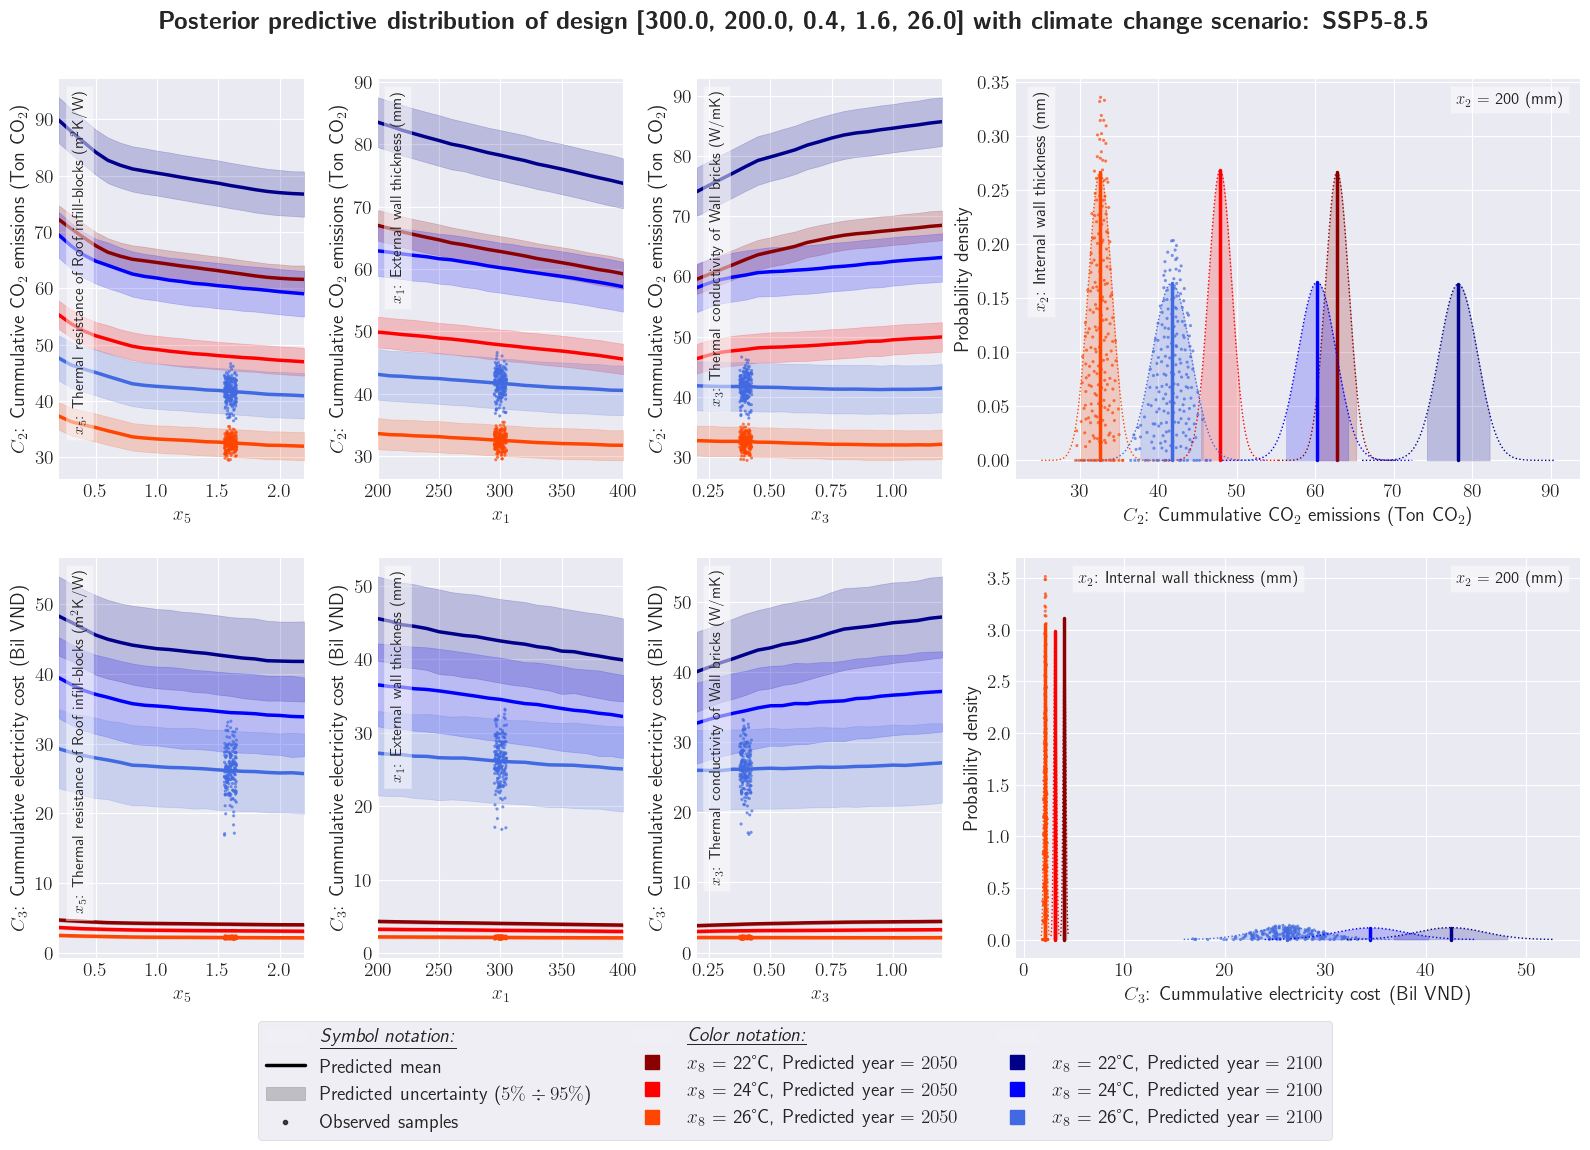

In [11]:
### Predict the sum of energy requirement for a random design sample
design_sample = data_df[input_variables].drop_duplicates()
random_sample = design_sample.iloc[58].to_numpy().reshape(1,-1)  # Baseline design sample: [300, 200, 0.4, 1.8, 26]
# random_sample = design_sample.sample(1).to_numpy().reshape(1,-1)
print(random_sample.tolist()[0])

obs_output_tensor = find_sample_output_tensor(data_df, input_variables, output_variables, random_sample, scaler_input, scalers_output, predictive)

climate_change_scenarios = ['SSP1-1.9', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
selected_climate_change_scenario = 4
inves_features = {'$x_{5}$': np.linspace(0.2, 2.2, 21),
                  '$x_{1}$': np.linspace(200, 400, 21),
                  '$x_{3}$': np.linspace(0.2, 1.2, 21),
                  '$x_{2}$': np.linspace(100, 300, 21)}
inves_cost_func = ['C2', 'C3']
inves_indoor_temperatures = [22, 24, 26]
inves_years = [2050, 2100]
color_list = [['darkred', 'darkblue'], ['red', 'blue'], ['orangered', 'royalblue']]

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['text.usetex'] = True
[nrows, ncols] = [2, 5]
fig = plt.figure(figsize=(16, 10))
fig.suptitle(r'\textbf{Posterior predictive distribution of design ' + rf'{str(random_sample.tolist()[0])}' + ' with climate change scenario: ' + rf'{str(climate_change_scenarios[selected_climate_change_scenario])}' + '}', y=1.01, fontsize=18)
gs = fig.add_gridspec(nrows, ncols)

for k in range(len(inves_features.keys())):
    col = list(inves_features.keys())[k]
    inves_val = list(inves_features.values())[k]

    for i in range(len(inves_cost_func)):
        row = inves_cost_func[i]
       
        if col != '$x_{2}$':
            ax1 = fig.add_subplot(gs[i, k])
        else:
            ax1 = fig.add_subplot(gs[i, k:])

        n_samples = len(inves_val)
        random_samples = np.repeat(random_sample, n_samples, axis=0)
        random_samples[:,input_variables.index(col)] = inves_val

        obs_func_tensor = find_sample_cost_func_tensor(obs_output_tensor, cost_func=row)
        
        for j in range(len(inves_indoor_temperatures)):
            random_samples[:,input_variables.index('$x_{8}$')] = inves_indoor_temperatures[j]

            pred_output_tensor = find_pred_output_tensor(random_samples, scaler_input, scalers_output, predictive)
            pred_func_tensor = find_pred_cost_func_tensor(pred_output_tensor, cost_func=row)
            for key, value in pred_func_tensor.items():
                pred_func_tensor[key] = pred_func_tensor[key][selected_climate_change_scenario]

            for m in range(len(inves_years)):
                selected_year = inves_years[m]
                
                if col != '$x_{2}$':
                    if inves_indoor_temperatures[j] == random_sample[0,-1]:
                        y = obs_func_tensor['obs']['data'][selected_climate_change_scenario].loc[inves_years[m]].values.flatten()
                        x = random_sample[0,input_variables.index(col)]
                        jittered_x = x * np.ones(len(y)) + np.random.uniform(-0.5*(inves_val[1]-inves_val[0]), 0.5*(inves_val[1]-inves_val[0]), len(y))
                        plt.scatter(x=jittered_x, y=y, color=color_list[j][m], edgecolor='none', s=5, alpha=0.7, zorder=1)

                    ax1.plot(inves_val, pred_func_tensor['mean'].loc[inves_years[m]], label=rf'Predicted mean ($x_{{8}}$ = {inves_indoor_temperatures[j]}°C)', 
                            color=color_list[j][m], linestyle='-', linewidth=2.5)

                    # z_low, z_high = stats.norm.ppf(0.5 - 0.6827 / 2), stats.norm.ppf(0.5 + 0.6827 / 2)
                    # ax1.plot(pred_func_tensor['mean'].loc[inves_years[m]] + z_low*pred_func_tensor['std'].loc[inves_years[m]], label=r"Predicted mean $\pm$ 1$\times$standard deviation ($68.27\%$)", color='darkgreen', linestyle='--')
                    # ax1.plot(pred_func_tensor['mean'].loc[inves_years[m]] + z_high*pred_func_tensor['std'].loc[inves_years[m]], color='darkgreen', linestyle='--')

                    ax1.fill_between(inves_val,
                                    pred_func_tensor['low_5'].loc[inves_years[m]].values.flatten(),
                                    pred_func_tensor['high_95'].loc[inves_years[m]].values.flatten(),
                                    label=rf'Predicted uncertainty ($5\% \div 95\%$) ($x_{{8}}$ = {inves_indoor_temperatures[j]}°C)', 
                                    color=color_list[j][m], alpha=0.2, zorder=1)
                else:
                    if inves_indoor_temperatures[j] == random_sample[0,-1]:
                        x = obs_func_tensor['obs']['data'][selected_climate_change_scenario].loc[inves_years[m]].values.flatten()
                        # sns.histplot(ax=ax1, x=x, kde=False, bins=21, color=color_list[j][m], edgecolor='none', linewidth=1.0, stat='density')

                        density = gaussian_kde(x)(x)
                        bins = np.histogram_bin_edges(x, bins=21)
                        bin_indices = np.digitize(x, bins)

                        y = np.zeros_like(x, dtype=float)
                        for i in range(1, len(bins)):
                            bin_mask = bin_indices == i
                            if bin_mask.any():
                                y[bin_mask] = np.linspace(0, density[bin_mask].max(), bin_mask.sum())
                        
                        plt.scatter(x=x, y=y, color=color_list[j][m], edgecolor='none', s=5, alpha=0.7, zorder=1)

                    selected_val = inves_val[len(inves_val) // 2]
                    idx = list(inves_val).index(selected_val)
                    mean_value = pred_func_tensor['mean'].loc[inves_years[m]].iloc[idx]
                    std_value = pred_func_tensor['std'].loc[inves_years[m]].iloc[idx]

                    if row == 'C2':
                        x = np.linspace(mean_value - 5 * std_value, mean_value + 5 * std_value, 200)
                    elif row == 'C3':
                        x = np.linspace(mean_value - 3 * std_value, mean_value + 3 * std_value, 200)
                    y = stats.norm.pdf(x, mean_value, std_value)

                    ax1.plot(x, y, color=color_list[j][m], linestyle=':', linewidth=1.0)
                    ax1.plot([mean_value, mean_value], [0, stats.norm.pdf(mean_value, mean_value, std_value)], 
                                color=color_list[j][m], linestyle='-', linewidth=2.5)       
                                 
                    ax1.fill_between(x, 0, y, where=(x >= pred_func_tensor['low_5'].loc[inves_years[m]].iloc[idx]) & 
                                        (x <= pred_func_tensor['high_95'].loc[inves_years[m]].iloc[idx]), 
                                        color=color_list[j][m], alpha=0.2)
            #     break
            # break
                    
        if col != '$x_{2}$':
            ax1.set_xlabel(rf'{col}', fontsize=14)            
            if row == 'y':
                ax1.set_ylabel(r'$y_{1}$: Yearly energy requirement (MWh)', fontsize=14)
            elif row == 'C1':
                ax1.set_ylabel(r'$C_{1}$: Cummulative energy consumption (GWh)', fontsize=14)
            elif row == 'C2':
                ax1.set_ylabel(r'$C_{2}$: Cummulative CO$_{2}$ emissions (Ton CO$_{2}$)', fontsize=14)
            elif row == 'C3':
                ax1.set_ylabel(r'$C_{3}$: Cummulative electricity cost (Bil VND)', fontsize=14)

            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlim(min(inves_val), max(inves_val))
            ax1.get_ylim()

            ax1.text(0.05, 0.97, rf'{input_variables_names[input_variables.index(col)]}', transform=ax1.transAxes, rotation=90, fontsize=11,
                ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
        else:
            if row == 'y':
                ax1.set_xlabel(r'$y_{1}$: Yearly energy requirement (MWh)', fontsize=14)
            elif row == 'C1':
                ax1.set_xlabel(r'$C_{1}$: Cummulative energy consumption (GWh)', fontsize=14)
            elif row == 'C2':
                ax1.set_xlabel(r'$C_{2}$: Cummulative CO$_{2}$ emissions (Ton CO$_{2}$)', fontsize=14)
            elif row == 'C3':
                ax1.set_xlabel(r'$C_{3}$: Cummulative electricity cost (Bil VND)', fontsize=14)
            
            ax1.set_ylabel('Probability density', fontsize=14)
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.get_xlim()
            ax1.get_ylim()

            if row == 'C2':
                ax1.text(0.03, 0.97, rf'{input_variables_names[input_variables.index(col)]}', transform=ax1.transAxes, rotation=90, fontsize=12,
                         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
            elif row == 'C3':
                ax1.text(0.11, 0.97, rf'{input_variables_names[input_variables.index(col)]}', transform=ax1.transAxes, fontsize=12,
                         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
            ax1.text(0.97, 0.97, rf'{col} = {int(selected_val)} (mm)', transform=ax1.transAxes, fontsize=12,
                     ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))
    #     break
    # break

handles, labels = [], []
handles.append(mpatches.Patch(color='white', alpha=0.1, zorder=1))
labels.append(r'\underline{\textit{Symbol notation:}}')
handles.append(mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5))
labels.append(r'Predicted mean')
handles.append(mpatches.Patch(color='black', alpha=0.2, zorder=1))
labels.append(rf'Predicted uncertainty ($5\% \div 95\%$)')
handles.append(mlines.Line2D([], [], color='black', linestyle='none', marker='o', markersize=3, alpha=0.7, zorder=1))
labels.append(r'Observed samples')

for m in range(len(inves_years)):
    handles.append(mpatches.Patch(color='white', alpha=0.1, zorder=1))
    if m == 0:
        labels.append(r'\underline{\textit{Color notation:}}')
    else:
        labels.append(r'')
    for j in range(len(inves_indoor_temperatures)):
        handles.append(mlines.Line2D([], [], color=color_list[j][m], linestyle='none', linewidth=2.5, marker='s', markersize=10))
        labels.append(rf'$x_{{8}}$ = {inves_indoor_temperatures[j]}°C, Predicted year $= {inves_years[m]}$')

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.13), ncols=3, fontsize=14, frameon=True)
plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.2, wspace=0.3)
plt.savefig(os.path.join(result_dir, 'Inves_Cost_func.png'), dpi=400, bbox_inches='tight')
plt.show()


In [23]:
# ((pred_func_tensor['std'][4] / pred_func_tensor['mean'][4]) / (pred_func_tensor['std'][2] / pred_func_tensor['mean'][2])).mean(axis=0)
((pred_func_tensor['std'][4] / pred_func_tensor['mean'][4]).mean(axis=0) / (pred_func_tensor['std'][2] / pred_func_tensor['mean'][2]).mean(axis=0))

# factor2 = ((pred_func_tensor['std'][4] / pred_func_tensor['mean'][4]) / 
#                (pred_func_tensor['std'][selected_climate_change_scenario] / pred_func_tensor['mean'][selected_climate_change_scenario])
#                ).mean(axis=0).to_numpy().flatten() 

1.0113054532305898